# Whitebox attack using privacy meter

## Introduction

In this tutorial we will see:

- How to use the privacy meter to audit model implemented on Pytorch
- How to extract the white-box signal (i.e., gradient norm)
- How to run membership inference attack based on white-box attack based on the population attack

<table class="tfo-notebook-buttons" align="left">
<td>
    <a target="_blank" href="https://colab.research.google.com/github/privacytrustlab/ml_privacy_meter/blob/master/tutorials/white_box_attack.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/privacytrustlab/ml_privacy_meter/blob/master/tutorials/white_box_attack.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View GitHub</a>
  </td>
</table>

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torchvision
import os
import pickle
import time
import copy

from torch import nn
from ast import List
from torchvision import transforms
from decimal import *
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scipy.special import comb

/home/wayne/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.metric import PopulationMetric
from privacy_meter.information_source_signal import ModelGradientNorm, ModelGradient, ModelLoss
from privacy_meter.hypothesis_test import linear_itp_threshold_func
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport
from privacy_meter.constants import InferenceGame
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource
from privacy_meter.model import PytorchModelTensor

2023-04-20 18:13:48.953791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 18:13:49.457199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-20 18:13:49.457249: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-20 18:13:49.457255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Define hyper-parameters

In [3]:
def rdp2dp(rdp, bad_event, alpha):
    """
    convert RDP to DP, Ref:
    - Canonne, Clément L., Gautam Kamath, and Thomas Steinke. The discrete gaussian for differential privacy. In NeurIPS, 2020. (See Proposition 12)
    - Asoodeh, S., Liao, J., Calmon, F.P., Kosut, O. and Sankar, L., A better bound gives a hundred rounds: Enhanced privacy guarantees via f-divergences. In ISIT, 2020. (See Lemma 1)
    """
    return rdp + 1.0/(alpha-1) * (np.log(1.0/bad_event) + (alpha-1)*np.log(1-1.0/alpha) - np.log(alpha))


def compute_rdp(alpha, q, sigma):
    """
    RDP for subsampled Gaussian mechanism, Ref:
    - Mironov, Ilya, Kunal Talwar, and Li Zhang. R\'enyi differential privacy of the sampled gaussian mechanism. arXiv preprint 2019.
    """
    sum_ = Decimal(0.0)
    for k in range(0, alpha+1):
        sum_ += Decimal(comb(alpha, k)) * Decimal(1-q)**Decimal(alpha-k) * Decimal(q**k) * Decimal(np.e)**(Decimal(k**2-k)/Decimal(2*sigma**2))
    rdp = sum_.ln() / Decimal(alpha-1)
    return float(rdp)

def search_dp(q, sigma, bad_event, iters=1):
    """
    Given the sampling rate, variance of Gaussian noise, and privacy parameter delta, 
    this function returns the corresponding DP budget.
    """
    min_dp = 1e5
    for alpha in list(range(2, 101)):
        rdp = iters * compute_rdp(alpha, q, sigma)
        dp = rdp2dp(rdp, bad_event, alpha)
        min_dp = min(min_dp, dp)
    return min_dp

def calibrating_sampled_gaussian(q, eps, bad_event, iters=1, err=1e-3):
    """
    Calibrate noise to privacy budgets
    """
    sigma_max = 100
    sigma_min = 0.1
    
    def binary_search(left, right):
        mid = (left + right) / 2
        
        lbd = search_dp(q, mid, bad_event, iters)
        ubd = search_dp(q, left, bad_event, iters)
        
        if ubd > eps and lbd > eps:    # min noise & mid noise are too small
            left = mid
        elif ubd > eps and lbd < eps:  # mid noise is too large
            right = mid
        else:
            print("an error occurs in func: binary search!")
            return -1
        return left, right
        
    # check
    if search_dp(q, sigma_max, bad_event, iters) > eps:
        print("noise > 100")
        return -1
    
    while sigma_max-sigma_min > err:
        sigma_min, sigma_max = binary_search(sigma_min, sigma_max)
    return sigma_max

In [4]:
# for training the target model
num_train_points = 1500
num_test_points = 1500
num_population_points = 3000
batch_size = 64
learning_rate = 0.01
local_epochs = 20
clients = 10
glob_epochs = 10

q = 0.01 # sampling rate
eps = 10.0 # privacy budget
delta = 1e-5 # probability of something bad happening
clip = 0.1
sigma = calibrating_sampled_gaussian(q, eps, delta, iters=local_epochs * glob_epochs, err=1e-3)
print("noise scale =", sigma)

device = 'cuda' if torch.cuda.is_available() else 'cpu' # you can change it to 'cuda' if you have GPU
mechanism = "DP"

# Define the model

In [ ]:

class Net(nn.Module):
    """Simple CNN for CIFAR10 dataset."""

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, inputs):
        """Forward pass of the model."""
        inputs = self.pool(F.relu(self.conv1(inputs)))
        inputs = self.pool(F.relu(self.conv2(inputs)))
        # flatten all dimensions except batch
        inputs = inputs.reshape(-1, 16 * 5 * 5)
        inputs = F.relu(self.fc1(inputs))
        inputs = F.relu(self.fc2(inputs))
        outputs = self.fc3(inputs)
        return outputs
    
class CNNMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        output = self.fc2(x)
        return output
    
class CNNCifar(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(64, 64, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, args.num_classes)
        self.fc1 = nn.Linear(64 * 4 * 4, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(-1, 16 * 5 * 5)
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) # input is color image, hence 3 i/p channels. 16 filters, kernal size is tuned to 3 to avoid overfitting, stride is 1 , padding is 1 extract all edge features.
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1) # We double the feature maps for every conv layer as in pratice it is really good.
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500) # I/p image size is 32*32, after 3 MaxPooling layers it reduces to 4*4 and 64 because our last conv layer has 64 outputs. Output nodes is 500
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10) # output nodes are 10 because our dataset have 10 different categories
    def forward(self, x):
      x = F.relu(self.conv1(x)) #Apply relu to each output of conv layer.
      x = F.max_pool2d(x, 2, 2) # Max pooling layer with kernal of 2 and stride of 2
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64) # flatten our images to 1D to input it to the fully connected layers
      x = F.relu(self.fc1(x))
      x = self.dropout1(x) # Applying dropout b/t layers which exchange highest parameters. This is a good practice
      x = self.fc2(x)
      return x
    
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

# Create the data

Load all the data

In [ ]:
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])
transform = transforms.Compose([transforms.ToTensor()])
all_data = torchvision.datasets.CIFAR10(
    root='.', train=True, download=True, transform=transform
)
test_data = torchvision.datasets.CIFAR10(
    root='.', train=False, download=True, transform=transform
)
all_features = np.concatenate([all_data.data, test_data.data], axis=0)
all_targets = np.concatenate([all_data.targets, test_data.targets], axis=0)

all_data.data = all_features
all_data.targets = all_targets

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def get_dataset_subset(dataset: torchvision.datasets, index: List(int)):
    """Get a subset of the dataset.

    Args:
        dataset (torchvision.datasets): Whole dataset.
        index (list): List of index.
    """
    assert max(index) < len(dataset) and min(index) >= 0, "Index out of range"
    data = (
        torch.from_numpy(dataset.data[index]).float().permute(0, 3, 1, 2) / 255
    )  # channel first
    targets = list(np.array(dataset.targets)[index])
    targets = torch.tensor(targets, dtype=torch.long)
    return data, targets

Split the data into train, test and population

In [ ]:
chosen_index = []
train_data, train_targets, test_data, test_targets, audit_data, audit_targets, train_index, test_index = [], [], [], [], [], [], [], []

all_index = np.arange(len(all_data))
for i in range(clients):
  train_i = np.random.choice([i for i in all_index if i not in chosen_index], num_train_points, replace=False)
  test_i = np.random.choice([i for i in all_index if i not in train_i and i not in chosen_index], num_test_points, replace=False)
  population_index = np.random.choice([i for i in all_index if i not in train_i and i not in test_i and i not in chosen_index], num_population_points, replace=False)
  chosen_index = np.concatenate((chosen_index,train_i,test_i,population_index))

  train_d, train_t = get_dataset_subset(all_data, train_i)
  test_d, test_t = get_dataset_subset(all_data, test_i)
  audit_d, audit_t = get_dataset_subset(all_data, population_index)
  train_data.insert(i, train_d)
  train_targets.insert(i, train_t)
  test_data.insert(i, test_d)
  test_targets.insert(i, test_t)
  audit_data.insert(i, audit_d)
  audit_targets.insert(i, audit_t)
  train_index.insert(i, train_i)
  test_index.insert(i, test_i)

Create the data loader for training the target model

In [ ]:
train_loader, test_loader = [], []
for i in range(clients):
  train_l = torch.utils.data.DataLoader(
              torch.utils.data.Subset(all_data,train_index[i]),
              batch_size=batch_size,
              shuffle=True,
              num_workers=4,
              pin_memory=True,
              persistent_workers=True,
              prefetch_factor=16)
  test_l = torch.utils.data.DataLoader(
              torch.utils.data.Subset(all_data,test_index[i]),
              batch_size=batch_size,
              shuffle=True,
              num_workers=4,
              pin_memory=True,
              persistent_workers=True,
              prefetch_factor=16)
  train_loader.insert(i, train_l)
  test_loader.insert(i, test_l)

# Train the target model

In [ ]:
def sec_func(model, criterion, device, train_data, train_targets, test_data, test_targets, audit_data, audit_targets):
    target_model = PytorchModelTensor(model_obj=model, loss_fn=criterion, device=device,batch_size=10)

    target_dataset = Dataset(
    data_dict={
        "train": {"x": train_data, "y": train_targets},
        "test": {"x": test_data, "y": test_targets},
    },
    default_input="x",
    default_output="y",
    )

    audit_dataset = Dataset(
        data_dict={"train": {"x": audit_data, "y": audit_targets}},
        default_input="x",
        default_output="y",
    )

    target_info_source = InformationSource(
        models=[target_model], 
        datasets=[target_dataset]
    )

    reference_info_source = InformationSource(
        models=[target_model],
        datasets=[audit_dataset]
    )

    metric = PopulationMetric(
                target_info_source=target_info_source,
                reference_info_source=reference_info_source,
                signals=[ModelLoss()],
                hypothesis_test_func=linear_itp_threshold_func,
            )
    audit_obj = Audit(
        metrics=metric,
        inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
        target_info_sources=target_info_source,
        reference_info_sources=reference_info_source,
        save_logs= False
    )
    audit_obj.prepare()
    return audit_obj.run()[0]

def test(model, device, test_loader):
    model.to(device)    
    # Validate the performance of the model 
    model.eval()
    # Assigning variables for computing loss and accuracy
    loss, acc, criterion = 0, 0, nn.CrossEntropyLoss()

    # Disable gradient calculation to save memory
    with torch.no_grad():
        for data, target in test_loader:
            # Moving data and target to the device
            data, target = data.to(device), target.to(device)
            # Cast target to long tensor
            target = target

            # Computing output and loss
            output = model(data)
            loss += criterion(output, target).item()

            # Computing accuracy
            pred = output.data.max(1, keepdim=True)[1]
            acc += pred.eq(target.data.view_as(pred)).sum()

        # Averaging the losses
        loss /= len(test_loader)

        # Calculating accuracy
        acc = float(acc) / len(test_loader.dataset)

    # Move the model back to the CPU to save memory
    model.to("cpu")
    return loss, 100. * acc

In [ ]:
def gaussian_noise(data_shape, s, sigma, device=None):
    """
    Gaussian noise
    """
    return torch.normal(0, sigma * s, data_shape).to(device)

def dp_train(model, device, idx, lr, epochs, train_loader, test_loader, train_data, train_targets, test_data, test_targets, audit_data, audit_targets, sec_record, q, BATCH_SIZE, clip, sigma, data_size):
    """local model update"""
    model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    start_time = time.time()
    # optimizer = torch.optim.Adam(self.model.parameters())
    
    for epoch_idx in range(epochs):
        # randomly select q fraction samples from data
        # according to the privacy analysis of moments accountant
        # training "Lots" are sampled by poisson sampling
        
        idx = np.where(np.random.rand(len(train_data)) < q)[0]

        sampled_dataset = TensorDataset(train_data[idx], train_targets[idx])
        sample_data_loader = torch.utils.data.DataLoader(
              dataset=sampled_dataset,
              batch_size=batch_size,
              shuffle=True,
              num_workers=4,
              pin_memory=True,
              persistent_workers=True,
              prefetch_factor=16)
        
        optimizer.zero_grad()

        clipped_grads = {name: torch.zeros_like(param) for name, param in model.named_parameters()}
        for batch_x, batch_y in sample_data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred_y = model(batch_x.float())
            loss = criterion(pred_y, batch_y.long())
            
            # bound l2 sensitivity (gradient clipping)
            # clip each of the gradient in the "Lot"
            for i in range(loss.size()[0]):
                loss[i].backward(retain_graph=True)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
                for name, param in model.named_parameters():
                    clipped_grads[name] += param.grad 
                model.zero_grad()
            # Add the loss to the total loss
            train_loss += loss.item()
                
        # add Gaussian noise
        for name, param in model.named_parameters():
            clipped_grads[name] += gaussian_noise(clipped_grads[name].shape, clip, sigma, device=device)
            
        # scale back
        for name, param in model.named_parameters():
            clipped_grads[name] /= (data_size * q)
        
        for name, param in model.named_parameters():
            param.grad = clipped_grads[name]
        
        # update local model
        optimizer.step()

        loss_audit_results = sec_func(copy.deepcopy(model), criterion, device, train_data, train_targets, test_data, test_targets, audit_data, audit_targets)
        # Print the epoch and loss summary
        print(f"ID: {idx} | Epoch: {epoch_idx+1}/{epochs} |", end=" ")
        print(f"Loss: {train_loss/len(train_loader):.4f} |", end=" ")
        print(f"Attack_acc: {100. * loss_audit_results[0].roc_auc:.2f}%")
    if idx == 0:
        loss_audit_results = sec_func(model, criterion, device, train_data, train_targets, test_data, test_targets, audit_data, audit_targets)
        sec_record.append(loss_audit_results[0].roc_auc)
    test_loss, test_acc = test(copy.deepcopy(model), device, test_loader)
    print(f"Test loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    print("training the target model uses: ", time.time() - start_time)
    return model.state_dict()

In [ ]:
glob_model = ResNet(ResidualBlock, [2, 2, 2])

def nor_train(model, device, idx, lr, epochs, train_loader, test_loader, train_data, train_targets, test_data, test_targets, audit_data, audit_targets, sec_record):
    model.to(device)
    model.train()

    # Set the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    start_time = time.time()
    # Loop over each epoch
    for epoch_idx in range(epochs):
        train_loss = 0
        # Loop over the training set
        for data, target in train_loader:
            # Move data to the device
            data, target = data.to(device, non_blocking=True), target.to(device,non_blocking=True)
            # Cast target to long tensor
            target = target

            # Set the gradients to zero
            optimizer.zero_grad(set_to_none=True)

            # Get the model output
            output = model(data)

            # Calculate the loss
            loss = criterion(output, target)

            # Perform the backward pass
            loss.backward()
            # Take a step using optimizer
            optimizer.step()

            # Add the loss to the total loss
            train_loss += loss.item()
        loss_audit_results = sec_func(copy.deepcopy(model), criterion, device, train_data, train_targets, test_data, test_targets, audit_data, audit_targets)
        # Print the epoch and loss summary
        print(f"ID: {idx} | Epoch: {epoch_idx+1}/{epochs} |", end=" ")
        print(f"Loss: {train_loss/len(train_loader):.4f} |", end=" ")
        print(f"Attack_acc: {100. * loss_audit_results[0].roc_auc:.2f}%")
    if idx == 0:
        loss_audit_results = sec_func(model, criterion, device, train_data, train_targets, test_data, test_targets, audit_data, audit_targets)
        sec_record.append(loss_audit_results[0].roc_auc)
    test_loss, test_acc = test(copy.deepcopy(model), device, test_loader)
    print(f"Test loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    print("training the target model uses: ", time.time() - start_time)
    return model.state_dict()

def aggregate(w_locals, clients, device):
    """FedAvg"""
    new_w = copy.deepcopy(w_locals[0])
    for name in new_w:
        new_w[name] = torch.zeros(new_w[name].shape).to(device)
    for idx in range(clients):
        for name in new_w:
            new_w[name] += w_locals[idx][name].to(device) * (1 / clients)
    return copy.deepcopy(new_w)

In [ ]:
sec_record = []
for j in range(glob_epochs):
    print("Global Epoch: ", j)
    w_locals = []
    for i in range(clients):
      if mechanism == 'None':
        w = nor_train(copy.deepcopy(glob_model), device, i, learning_rate, local_epochs, train_loader[i], test_loader[i], train_data[i], train_targets[i], test_data[i],
                      test_targets[i], audit_data[i], audit_targets[i], sec_record)
      elif mechanism == 'DP':
         w = dp_train(copy.deepcopy(glob_model), device, i, learning_rate, local_epochs, train_loader[i], test_loader[i], train_data[i], train_targets[i], test_data[i],
                      test_targets[i], audit_data[i], audit_targets[i], sec_record, q, batch_size, clip, sigma, len(train_loader[i]))
      w_locals.insert(i, copy.deepcopy(w))

    new_glob_w = aggregate(w_locals, clients, device)
    glob_model.load_state_dict(copy.deepcopy(new_glob_w))
    randon_id = np.random.choice(range(clients), 1, replace=False)[0]
    glob_loss, glob_acc = test(copy.deepcopy(glob_model), device, test_loader[randon_id])
    print(f"Global epoch {j}: Test loss: {glob_loss:.4f} | Test Acc: {glob_acc:.2f}%")

plt.figure()
plt.ylabel('Attack Accuracy')
plt.xlabel('Global Epoch')
plt.plot(range(len(sec_record)), sec_record, label='{}'.format("No-DP"))
plt.title('{} Attack Accuracy'.format('Cifar'))
plt.legend()
plt.savefig('test.png')

Global Epoch:  0
loss.size:  2.180022716522217


IndexError: tuple index out of range

# Wrap the target model and datasets
The `batch_size` parameter determines the number of samples used in each iteration when computing the signals. Larger batch sizes can increase computation speed, but they also consume more memory. If you're computing the loss, you can use a larger batch size, but if you're using the GPU to compute gradient information such as gradient norm, using a batch size that is too large may result in an Out Of Memory (OOM) error. This is largely dependent on the size of your model and the memory capacity of your GPU. As a general guideline, we recommend using a batch size of 10 when computing gradient information

In [ ]:

target_model = PytorchModelTensor(model_obj=model, loss_fn=criterion, device=device,batch_size=10)

NameError: name 'model' is not defined

Get the dataset in the tensor formate

In [ ]:

def get_dataset_subset(dataset: torchvision.datasets, index: List(int)):
    """Get a subset of the dataset.

    Args:
        dataset (torchvision.datasets): Whole dataset.
        index (list): List of index.
    """
    assert max(index) < len(dataset) and min(index) >= 0, "Index out of range"
    print(torch.from_numpy(dataset.data[index]).shape)
    print(torch.from_numpy(dataset.data[index]).float().permute(0, 3, 1, 2).shape)
    data = (
        torch.from_numpy(dataset.data[index]).float().permute(0, 3, 1, 2) / 255
    )  # channel first
    targets = list(np.array(dataset.targets)[index])
    targets = torch.tensor(targets, dtype=torch.long)
    return data, targets

In [ ]:
train_data, train_targets = get_dataset_subset(all_data, train_index)
test_data, test_targets = get_dataset_subset(all_data, test_index)
audit_data, audit_targets = get_dataset_subset(all_data, population_index)
target_dataset = Dataset(
    data_dict={
        "train": {"x": train_data, "y": train_targets},
        "test": {"x": test_data, "y": test_targets},
    },
    default_input="x",
    default_output="y",
)

audit_dataset = Dataset(
        data_dict={"train": {"x": audit_data, "y": audit_targets}},
        default_input="x",
        default_output="y",
)
 


torch.Size([600, 32, 32, 3])
torch.Size([600, 3, 32, 32])
torch.Size([600, 32, 32, 3])
torch.Size([600, 3, 32, 32])
torch.Size([1200, 32, 32, 3])
torch.Size([1200, 3, 32, 32])


# Create Information Sources

In [ ]:
target_info_source = InformationSource(
    models=[target_model], 
    datasets=[target_dataset]
)

reference_info_source = InformationSource(
    models=[target_model],
    datasets=[audit_dataset]
)

# Metric and Audit 
We assess the privacy risk of our trained model using a population attack that is based on both the loss of the target model and the gradient norm of the target model. The results based on the loss indicate the privacy risk of the model in a black-box setting, where the adversary does not have access to the entire model. Conversely, computing the gradient norm per sample requires the adversary to have access to the entire model parameters, which corresponds to a white-box setting.

In [ ]:
metric = PopulationMetric(
            target_info_source=target_info_source,
            reference_info_source=reference_info_source,
            signals=[ModelLoss()],
            hypothesis_test_func=linear_itp_threshold_func,
        )
audit_obj = Audit(
    metrics=metric,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
)
audit_obj.prepare()
loss_audit_results = audit_obj.run()[0]

In [ ]:
metric = PopulationMetric(
            target_info_source=target_info_source,
            reference_info_source=reference_info_source,
            signals=[ModelGradientNorm()],
            hypothesis_test_func=linear_itp_threshold_func,
        )
audit_obj = Audit(
    metrics=metric,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
)
audit_obj.prepare()
gradient_norm_audit_results = audit_obj.run()[0]

/usr/local/lib/python3.9/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


# Compare the results

In [ ]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'

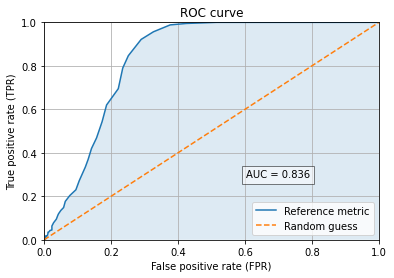

0.8357833333333333


<Figure size 432x288 with 0 Axes>

In [ ]:
ROCCurveReport.generate_report(
    metric_result=loss_audit_results[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)
print(loss_audit_results[0].roc_auc)

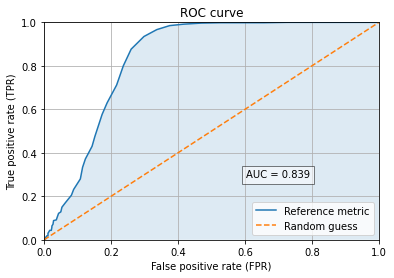

<Figure size 432x288 with 0 Axes>

In [ ]:
ROCCurveReport.generate_report(
    metric_result=gradient_norm_audit_results[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)